In [188]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

In [189]:
print('number of GPU', torch.cuda.device_count())
print('gpu name',torch.cuda.get_device_name())
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

number of GPU 1
gpu name NVIDIA GeForce MX450
using device: cuda


In [190]:
shape_ = loadmat('ShapeData.mat')
stress = loadmat('StressData.mat')

In [191]:
X = shape_['ShapeData']
Y = stress['StressData']
# spliting traininng data
index = np.random.choice(X.shape[1],size = int(X.shape[1] * 0.8), replace =False)
x_train = X[:,index]
y_train = Y[:,:,index]

x_test = np.delete(X,index,axis=1)
y_test = np.delete(Y,index,axis=2)
print(f'shape of trianing data {x_train.shape,y_train.shape } and testing data{x_test.shape ,y_test.shape}')

shape of trianing data ((15000, 583), (4, 5000, 583)) and testing data((15000, 146), (4, 5000, 146))


In [192]:
# pca
from sklearn.decomposition import PCA
nx , ny = 5, 90
pca_x = PCA(n_components = nx)
x_train_enc = (torch.from_numpy(pca_x.fit_transform(x_train.T))).to(device)
x_test_enc = (torch.from_numpy(pca_x.transform(x_test.T))).to(device)


pca_y = PCA(n_components = ny)
y_train_ = y_train.reshape(-1,y_train.shape[2])
y_test_ = y_test.reshape(-1,y_test.shape[2])

y_train_enc = (torch.from_numpy( pca_y.fit_transform((y_train_).T))).to(device)
y_test_enc = (torch.from_numpy(pca_y.transform(y_test_.T))).to(device)
print(f'''Reduced dimensional space
x data for test { x_test_enc.shape } and training {x_train_enc.shape},
y data for test {y_test_enc.shape} and training {y_train_enc.shape }''')

Reduced dimensional space
x data for test torch.Size([146, 5]) and training torch.Size([583, 5]),
y data for test torch.Size([146, 90]) and training torch.Size([583, 90])


In [193]:
# define
def dataloader(x ,y , batch_size):
    idx = np.random.choice(x.shape[0],size = batch_size,replace=False)
    return (x[idx,:]) , (y[idx,:])



In [194]:
# create model
class neuralnet(nn.Module):
    def __init__(self,nx,ny):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nx, 512),
            nn.ReLU(),
            nn.Linear(512, 16),
            nn.ReLU(),
            nn.Linear(16, 512),
            nn.ReLU(),
            nn.Linear(512, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 256),
            nn.ReLU(),
            nn.Linear(256, ny)  # Final output layer with 15 neurons
        )
    def forward(self,x):
        return self.model(x)

    def RMSE(self , y_true,y_pred):
        mse_loss = torch.sum((y_true - y_pred )** 2)  # Sum of squared errors
        norm_factor = torch.sum(y_true ** 2) + 1e-8
        return mse_loss / norm_factor
model = neuralnet(nx,ny).to(device)
print(model)

neuralnet(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=90, bias=True)
  )
)


In [195]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2.3e-4)

def train_cy(x,y,model,optimizer):
    input_, output_ = dataloader(x_train_enc.to(torch.float32) , y_train_enc.to(torch.float32),batch_size)
    k=0
    for i in range(input_.shape[0]):
        y_pred = model(input_[i,:])
        loss = model.RMSE(output_[i,:],y_pred)

         # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        k+=loss.item()

    return k/i



In [196]:
def test_cy(x,y,model):
    model.eval()
    input_, output_ = dataloader(x_test_enc.to(torch.float32) , y_test_enc.to(torch.float32),batch_size)
    k=0
    for i in range(input_.shape[0]):
        y_pred = model(input_[i,:])
        loss = model.RMSE(output_[i,:],y_pred)
        k+=loss.item()

    return k/i



In [197]:
# training loop
epoch = 100
batch_size =64
loss_train = []
loss_test =[]
for _ in range(epoch):

    loss_train.append(train_cy(x_train_enc,y_train_enc,model,optimizer))

    loss_test.append(test_cy(x_test_enc,y_test_enc,model))

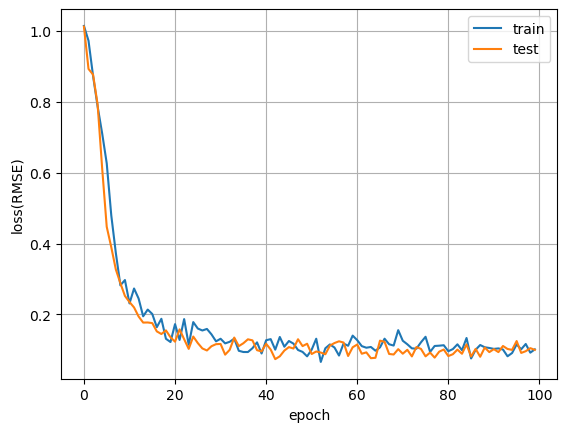

In [198]:
import matplotlib.pyplot as plt
plt.plot(loss_train,label = 'train')
plt.plot(loss_test, label = 'test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss(RMSE)')
plt.grid()
plt.show()


In [199]:
# recontrion error
def mean_absolute_error(o ,t):
    return np.mean(np.abs((o - t)))
x_train_inv = pca_x.inverse_transform(x_train_enc.cpu())
y_train_inv = pca_y.inverse_transform(y_train_enc.cpu())
rec_x = mean_absolute_error(x_train, x_train_inv.T)
rec_y = mean_absolute_error(y_train_, y_train_inv.T)
print(f"Reconstruction Error (training data) x : {rec_x}, y : {rec_y}")

x_test_inv = pca_x.inverse_transform(x_test_enc.cpu())
y_test_inv = pca_y.inverse_transform(y_test_enc.cpu())
rec_x = mean_absolute_error(x_test, x_test_inv.T)
rec_y = mean_absolute_error(y_test_, y_test_inv.T)
print(f"Reconstruction Error (testing data) x : {rec_x}, y : {rec_y}")

print(f"Final training loss is {loss_train[-1]}")
print(f"Final testing loss is {loss_test[-1]}")


Reconstruction Error (training data) x : 1.8781485060598537e-09, y : 0.16014010624974354
Reconstruction Error (testing data) x : 1.891469509935039e-09, y : 0.19470393539204886
Final training loss is 0.1015488032754215
Final testing loss is 0.10019091791695073


In [200]:
# prediction
model.eval()
with torch.inference_mode():
  pred_test = model(x_test_enc.to(torch.float32))
  loss = model.RMSE(y_test_enc , pred_test)
print(f"{loss*100:.2f} % ")

7.34 % 


In [201]:
# decoder
y_out = pca_y.inverse_transform(pred_test.cpu().detach().numpy()).T.reshape(4,5000,-1)
y_out.shape

(4, 5000, 146)

In [202]:
#error =(y_out - y_test)/(y_test + 1e-3) *100
error = torch.abs(torch.from_numpy(y_out) - torch.from_numpy(y_test)) / (torch.abs(torch.from_numpy(y_test)) + 1e-3) * 100
print(error.shape)

torch.Size([4, 5000, 146])


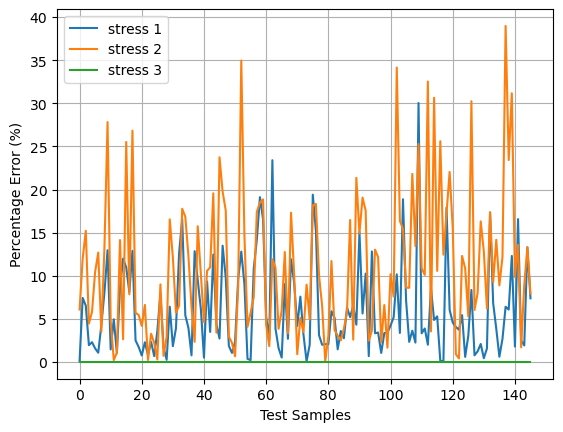

In [203]:
#plotting error
plt.plot(error[0,1,:],label='stress 1')
plt.plot(error[1,1,:],label='stress 2')
plt.plot(error[2,5,:],label='stress 3')
plt.xlabel('Test Samples')
plt.ylabel('Percentage Error (%)')
plt.legend()

plt.grid()
plt.show()



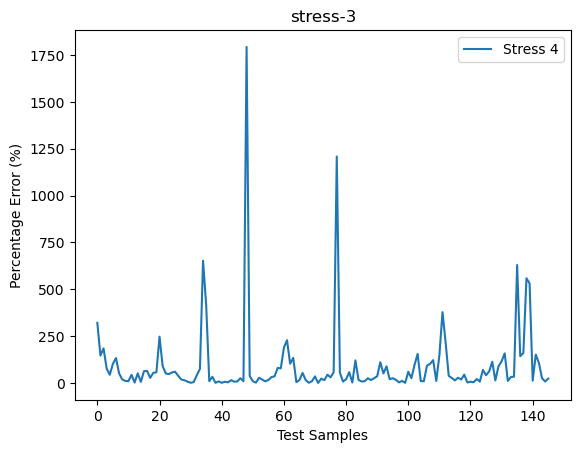

In [204]:
plt.title('stress-3')
plt.plot(error[3,5,:],label='Stress 4')
plt.xlabel('Test Samples')
plt.ylabel('Percentage Error (%)')
plt.legend()
plt.show()

(8, 729)


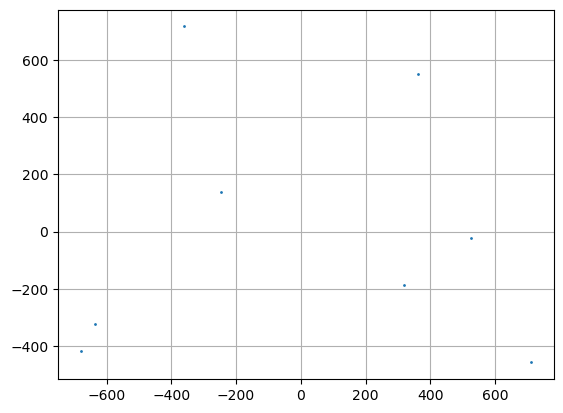

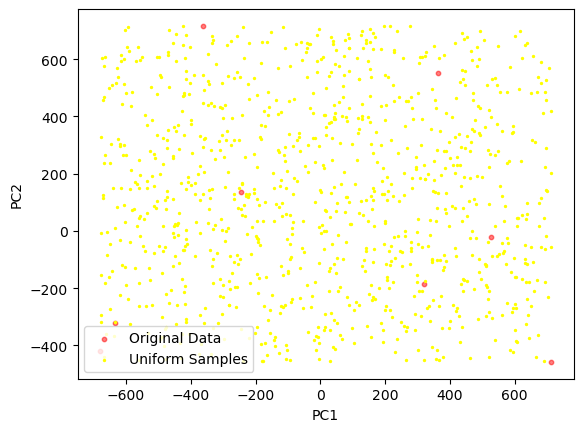

In [205]:
# plotting  the 2 pc for data
from sklearn.decomposition import PCA
idx =np.random.choice(729,size=8,replace=False)
pca_2 = PCA(n_components =2)
print(shape_['ShapeData'][idx].shape)
x_2pc = pca_2.fit_transform(shape_['ShapeData'][:,idx].T)
plt.scatter(x_2pc[:,0],x_2pc[:,1],s=1)
plt.grid()
plt.show()

# code to generate the artificaial data  
pc1_min, pc1_max = x_2pc[:, 0].min(), x_2pc[:, 0].max()
pc2_min, pc2_max = x_2pc[:, 1].min(), x_2pc[:, 1].max()

# Generate uniform samples in the PC space
num_samples = 1000
pc1_samples = np.random.uniform(pc1_min, pc1_max, num_samples)
pc2_samples = np.random.uniform(pc2_min, pc2_max, num_samples)
X_sampled_pca = np.column_stack((pc1_samples, pc2_samples))

# Plot the results
plt.scatter(x_2pc[:, 0], x_2pc[:, 1], alpha=0.5,s=10,color='red', label="Original Data")
plt.scatter(X_sampled_pca[:, 0], X_sampled_pca[:, 1],s=2, color='yellow', label="Uniform Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.savefig('pc1vspc2_syntheic data.png')
plt.show()

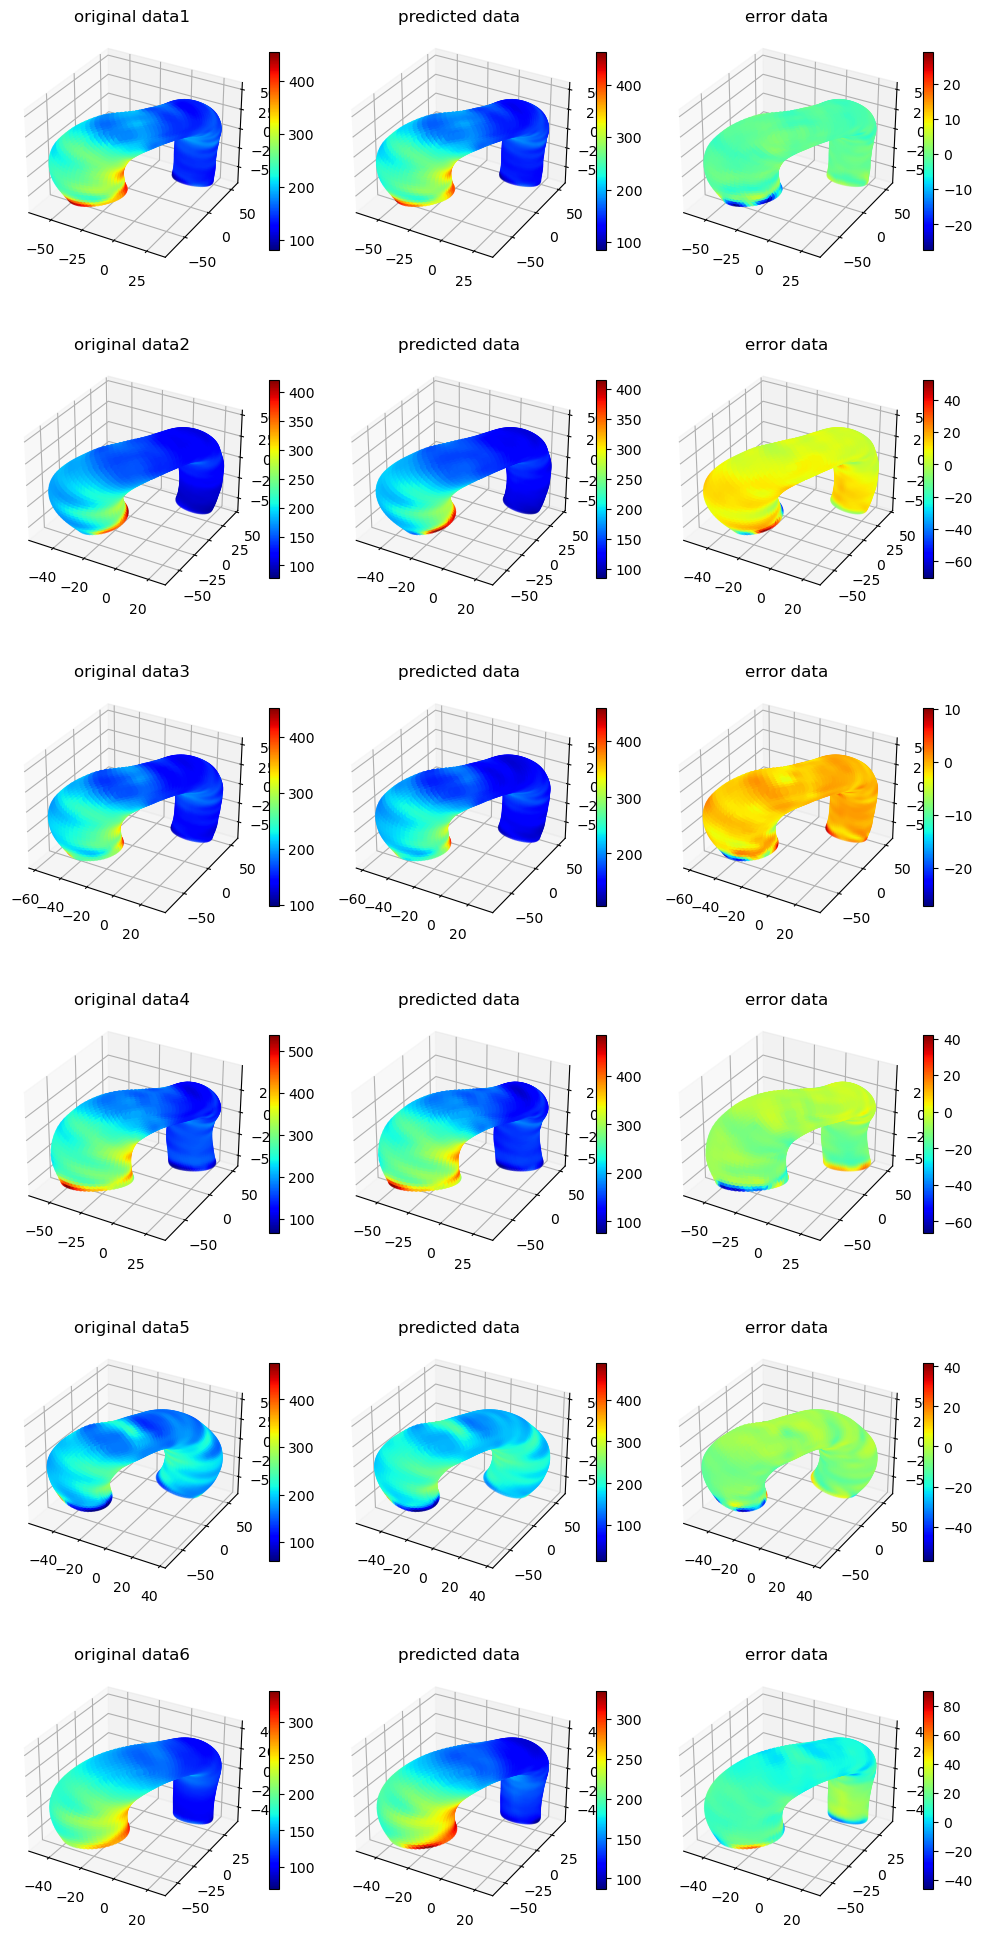

In [206]:
import numpy as np
import matplotlib.pyplot as plt
geo =np.random.choice(146,size=18,replace=False)


# Create a 3D scatter plot
fig = plt.figure(figsize=(10,20))
for i in range(1,18,3):
    xx=x_test[:,geo[i]].reshape(-1,3)
    x = xx[:,0]
    y = xx[:,1]
    z = xx[:,2]
    ax = fig.add_subplot(6,3,i, projection='3d')
    ssd1 =ax.scatter(x, y, z, c=y_test[0,:,geo[i]], cmap="jet", marker='o')
    cbar = fig.colorbar(ssd1, ax=ax, shrink=0.6, aspect=20)

    ax.set_title("original data" + str(1+i//3))
    
    ax = fig.add_subplot(6,3,i+1, projection='3d')
    ssd = ax.scatter(x, y, z, c=y_out[0,:,geo[i]], cmap="jet", marker='o')

    ax.set_title("predicted data")
    cbar = fig.colorbar(ssd, ax=ax, shrink=0.6, aspect=20)
    # cbar.set_label("Point Value (Z-Axis)")  # Label for color scale

    ax = fig.add_subplot(6,3,i+2, projection='3d')
    ssd = ax.scatter(x, y, z, c=y_out[0,:,geo[i]] - y_test[0,:,geo[i]], cmap="jet", marker='o')

    ax.set_title("error data")
    cbar = fig.colorbar(ssd, ax=ax, shrink=0.6, aspect=20)
plt.tight_layout()
plt.savefig("original_vs_test_1.png", dpi=300, bbox_inches='tight',)
plt.show()

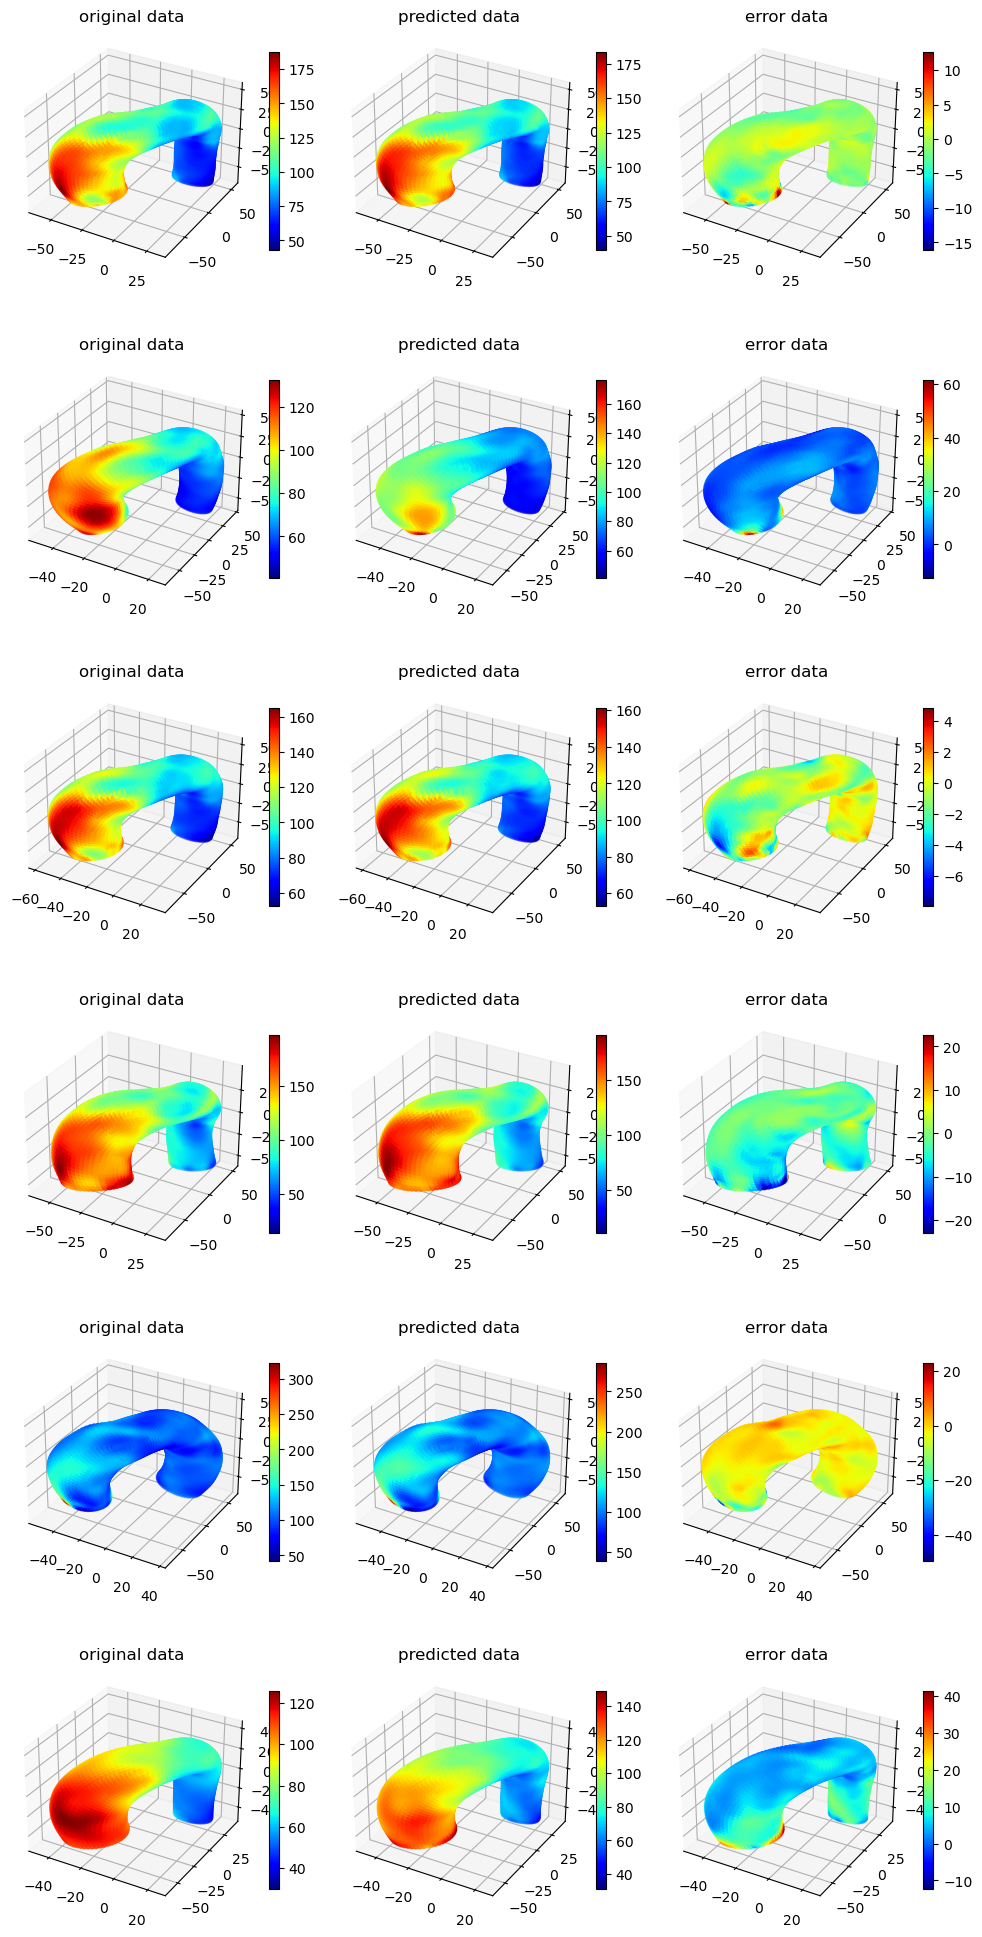

In [207]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10,20))
for i in range(1,18,3):
    xx=x_test[:,geo[i]].reshape(-1,3)
    x = xx[:,0]
    y = xx[:,1]
    z = xx[:,2]
    ax = fig.add_subplot(6,3,i, projection='3d')
    ssd1 =ax.scatter(x, y, z, c=y_test[1,:,geo[i]], cmap="jet", marker='o')
    cbar = fig.colorbar(ssd1, ax=ax, shrink=0.6, aspect=20)

    ax.set_title("original data")
    
    ax = fig.add_subplot(6,3,i+1, projection='3d')
    ssd = ax.scatter(x, y, z, c=y_out[1,:,geo[i]], cmap="jet", marker='o')

    ax.set_title("predicted data")
    cbar = fig.colorbar(ssd, ax=ax, shrink=0.6, aspect=20)
    # cbar.set_label("Point Value (Z-Axis)")  # Label for color scale

    ax = fig.add_subplot(6,3,i+2, projection='3d')
    ssd = ax.scatter(x, y, z, c=y_out[1,:,geo[i]] - y_test[1,:,geo[i]], cmap="jet", marker='o')

    ax.set_title("error data")
    cbar = fig.colorbar(ssd, ax=ax, shrink=0.6, aspect=20)
plt.tight_layout()
plt.savefig("original_vs_test_2.png", dpi=300, bbox_inches='tight',)
plt.show()

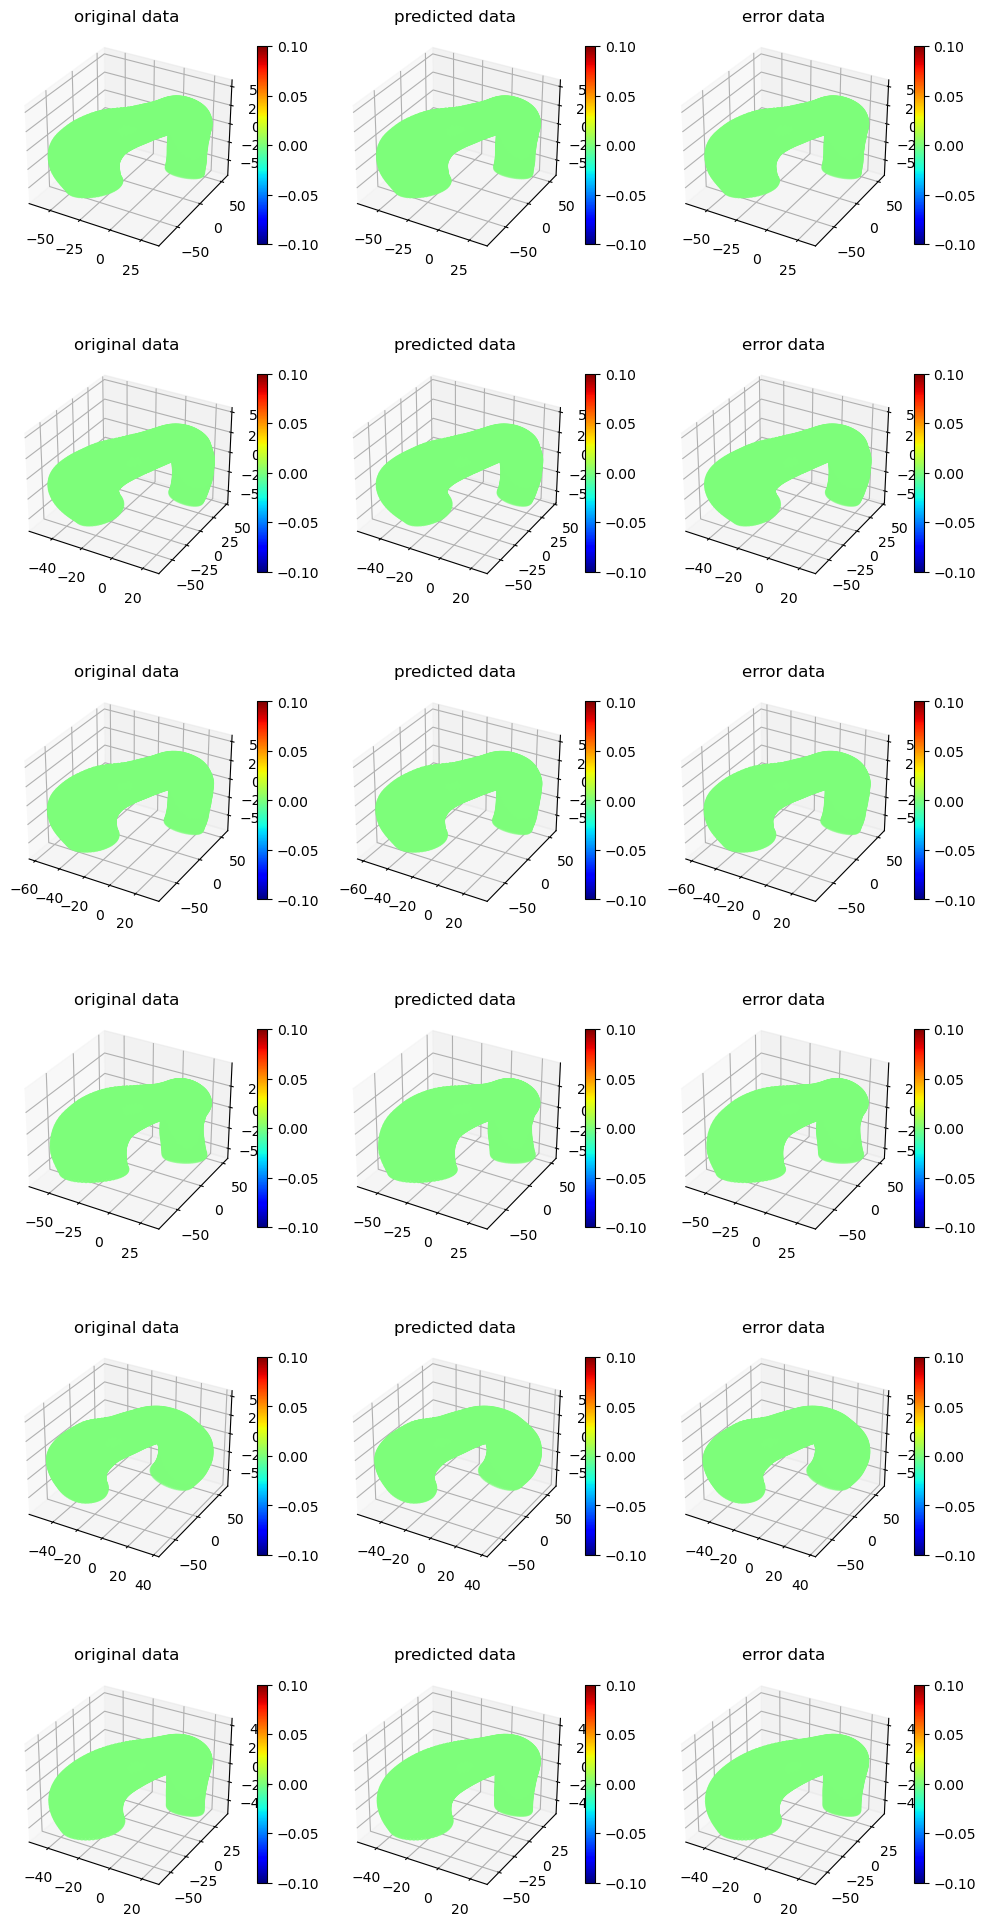

In [208]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10,20))
for i in range(1,18,3):
    xx=x_test[:,geo[i]].reshape(-1,3)
    x = xx[:,0]
    y = xx[:,1]
    z = xx[:,2]
    ax = fig.add_subplot(6,3,i, projection='3d')
    ssd1 =ax.scatter(x, y, z, c=y_test[2,:,geo[i]], cmap="jet", marker='o')
    cbar = fig.colorbar(ssd1, ax=ax, shrink=0.6, aspect=20)

    ax.set_title("original data")
    
    ax = fig.add_subplot(6,3,i+1, projection='3d')
    ssd = ax.scatter(x, y, z, c=y_out[2,:,geo[i]], cmap="jet", marker='o')

    ax.set_title("predicted data")
    cbar = fig.colorbar(ssd, ax=ax, shrink=0.6, aspect=20)
    # cbar.set_label("Point Value (Z-Axis)")  # Label for color scale

    ax = fig.add_subplot(6,3,i+2, projection='3d')
    ssd = ax.scatter(x, y, z, c=y_out[2,:,geo[i]] - y_test[2,:,geo[i]], cmap="jet", marker='o')

    ax.set_title("error data")
    cbar = fig.colorbar(ssd, ax=ax, shrink=0.6, aspect=20)
plt.tight_layout()
plt.savefig("original_vs_test_3.png", dpi=300, bbox_inches='tight',)
plt.show()

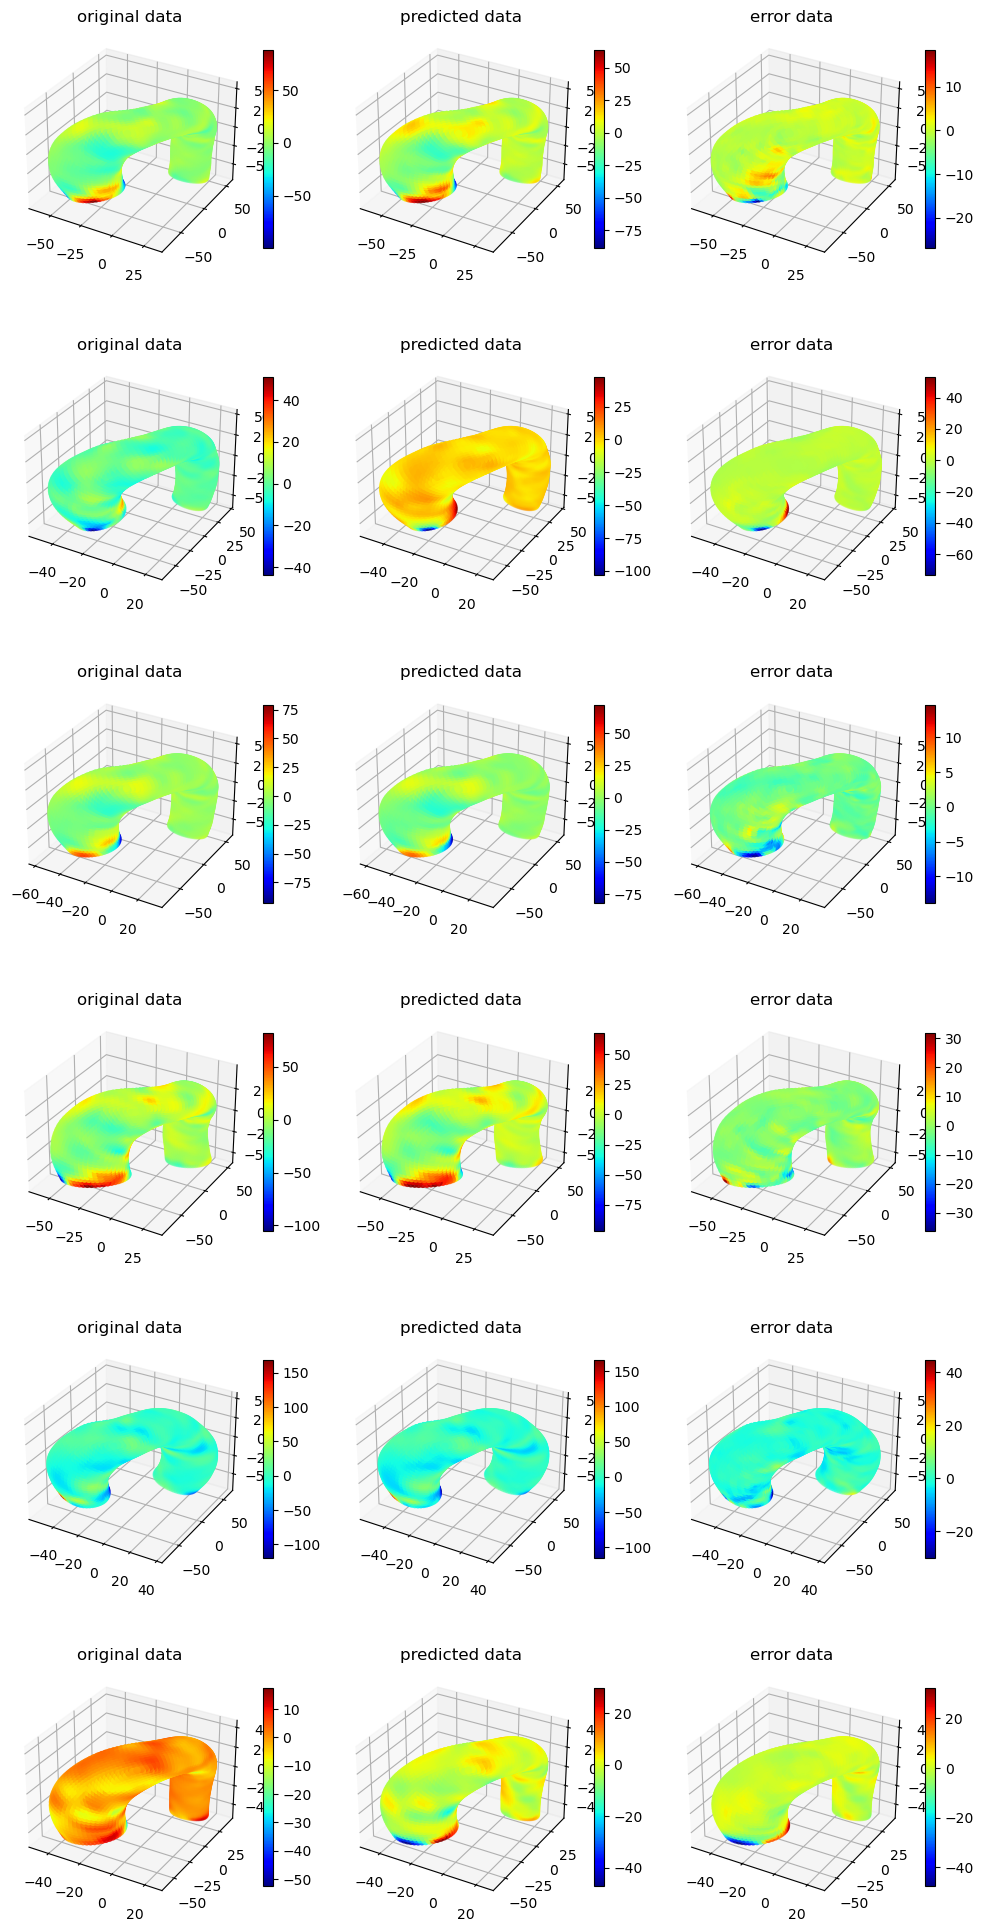

In [209]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10,20))
for i in range(1,18,3):
    xx=x_test[:,geo[i]].reshape(-1,3)
    x = xx[:,0]
    y = xx[:,1]
    z = xx[:,2]
    ax = fig.add_subplot(6,3,i, projection='3d')
    ssd1 =ax.scatter(x, y, z, c=y_test[3,:,geo[i]], cmap="jet", marker='o')
    cbar = fig.colorbar(ssd1, ax=ax, shrink=0.6, aspect=20)

    ax.set_title("original data")
    
    ax = fig.add_subplot(6,3,i+1, projection='3d')
    ssd = ax.scatter(x, y, z, c=y_out[3,:,geo[i]], cmap="jet", marker='o')

    ax.set_title("predicted data")
    cbar = fig.colorbar(ssd, ax=ax, shrink=0.6, aspect=20)
    # cbar.set_label("Point Value (Z-Axis)")  # Label for color scale

    ax = fig.add_subplot(6,3,i+2, projection='3d')
    ssd = ax.scatter(x, y, z, c=y_out[3,:,geo[i]] - y_test[3,:,geo[i]], cmap="jet", marker='o')

    ax.set_title("error data")
    cbar = fig.colorbar(ssd, ax=ax, shrink=0.6, aspect=20)
plt.tight_layout()
plt.savefig("original_vs_test_4.png", dpi=300, bbox_inches='tight',)
plt.show()

In [210]:
np.sum((y_train_- y_train_inv.T)/(y_train_+1e-2))

-646779.7911656934

In [211]:
# MAE
x_test.reshape(3,-1).shape



(3, 730000)

In [212]:
y_test.shape

(4, 5000, 146)

In [213]:
y_out.shape

(4, 5000, 146)

In [214]:
MAE = np.abs(y_test - y_out).mean(axis=1)
NMAE = MAE/MAE.max(axis = 0).shape

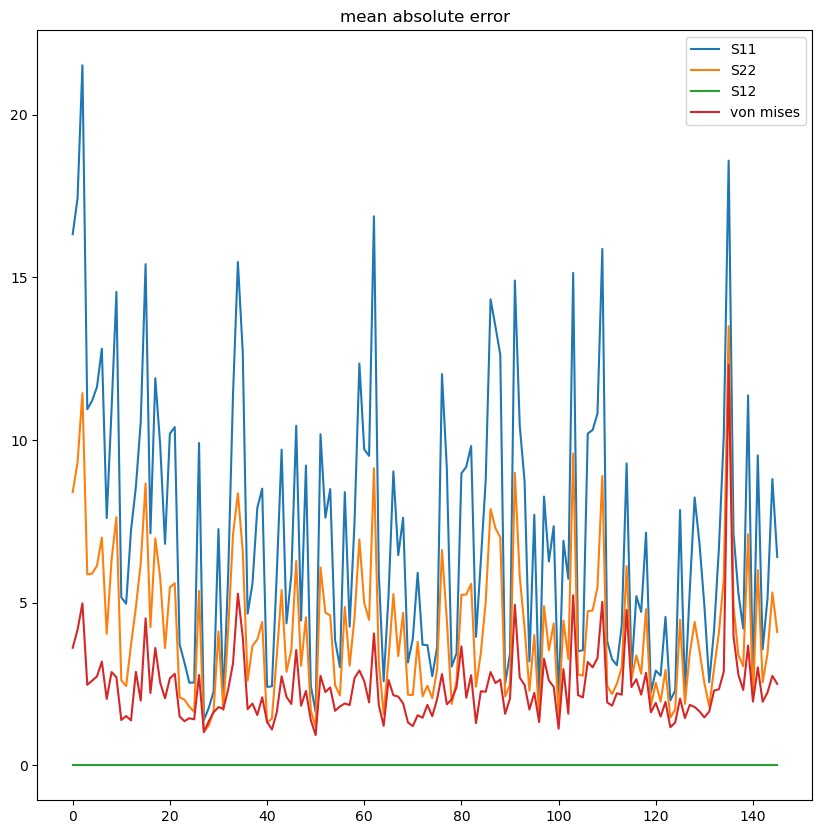

In [215]:
plt.figure(figsize=(10,10))
plt.plot(MAE[0,:], label = 'S11')
plt.plot(MAE[1,:], label = 'S22')
plt.plot(MAE[2,:], label = 'S12')
plt.plot(MAE[3,:], label = 'von mises')
plt.legend()
plt.title('mean absolute error')
plt.show()

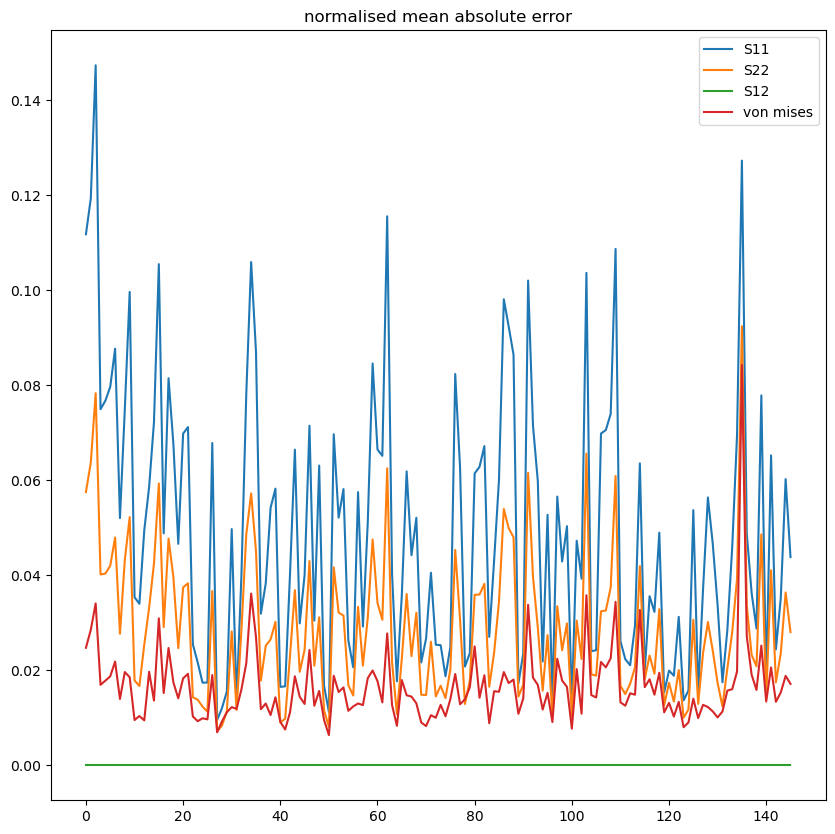

In [231]:
plt.figure(figsize=(10,10))
plt.plot(NMAE[0,:], label = 'S11')
plt.plot(NMAE[1,:], label = 'S22')
plt.plot(NMAE[2,:], label = 'S12')
plt.plot(NMAE[3,:], label = 'von mises')
plt.legend()
plt.title('normalised mean absolute error')
plt.show()

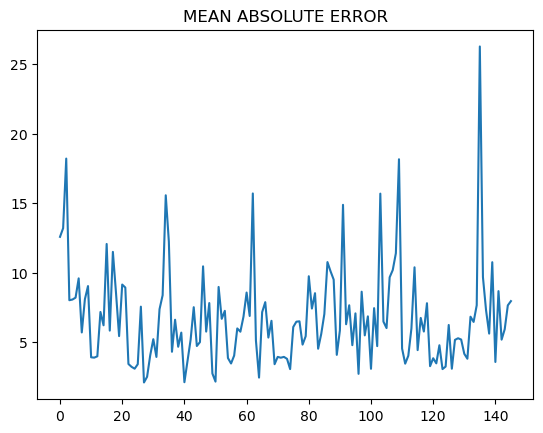

In [235]:

MAE_std  = (y_test - y_out).std(axis=1)
plt.plot(MAE_std[0,:])
plt.title('MEAN ABSOLUTE ERROR')
plt.show()

In [230]:
a= np.random.randint(146)
MAE[:,a], MAE_std[:,a]

(array([4.91745288, 2.52847622, 0.        , 1.47201053]),
 array([4.16630966, 2.55354592, 0.        , 2.68047384]))

In [229]:
a

81